# ML Final Project

## Data Preprocessing

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import random

from scipy import sparse

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [13]:
# import the data (chunksize returns jsonReader for iteration)
businesses = pd.read_json("yelp_academic_dataset_business.json", lines=True, orient='columns', chunksize=200000)
reviews = pd.read_json("yelp_academic_dataset_review.json", lines=True, orient='columns', chunksize=200000)

In [14]:
# read the data
for business in businesses:
    business_chunk = business
    break

for review in reviews:
    review_chunk = review
    break

In [19]:
len(review_chunk[review_chunk['stars']==2])

16116

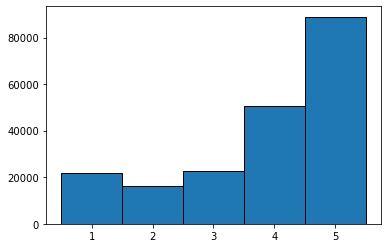

In [18]:
plt.hist(review_chunk['stars'], range=(0.5,5.5), bins=5, edgecolor="black")
plt.show()

We verified that there weren't any null values in the stars category within our dataset.

In [21]:
review_chunk['stars'].isna().sum()

0

In [22]:
review_chunk['stars'].isnull().sum()

0

In [26]:
business_chunk.iloc[0]['categories']


'Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists'

Per our problem statement, we restrict establishments to those who identify themselves as restaurants.

In [27]:
# To create a df of reviews of Restaurants
a = business_chunk[business['categories'].str.contains('Restaurant') == True]
rev = review_chunk[review_chunk.business_id.isin(a['business_id']) == True]

In [29]:
rev.shape

(144425, 9)

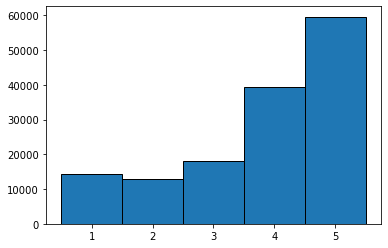

In [30]:
plt.hist(rev['stars'], range=(0.5,5.5), bins=5, edgecolor="black")
plt.show()

As you can see, the data is skewed more toward reviews with higher ratings. Below, we take steps to evenly distribute the reviews so the model doesn't skew toward a specific stars value.

In [31]:
len(rev[rev['stars']==2])

12836

In [32]:
# function to take equal sample from existing dataframe
def equal_sample(df, target_column, sample_size):
    grouped = df.groupby(target_column, group_keys=False)
    sampled_df = grouped.apply(lambda x: x.sample(min(len(x), sample_size)))
    return sampled_df

In [33]:
df = equal_sample(rev, 'stars', 12000)

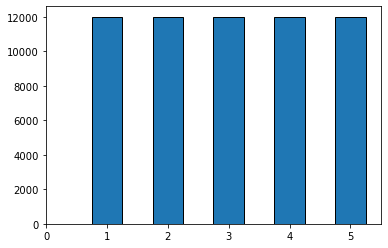

In [61]:
plt.hist(df['stars'], range=(0.25, 5.25), edgecolor='black')
plt.show()

In [37]:
df.iloc[11998:12002]

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
120541,qrc6_i4ZphAbHlBDKBh5uw,lGMCV5BHXnjbyurOhuQPLA,wHyRfaCUBVG9GfXkNIzLzA,1,1,0,0,So gross. We were in a mood for some wings and...,2013-08-18 12:24:00
119243,N4S4Ok_ePQV4a3D8zoXbNA,M6h21fv71wG8UtKfAbn8wA,py5aKmlTB2NarfsfcOpHOQ,1,1,0,0,I am fine with the mediocre food in the airpor...,2017-04-10 20:50:53
50160,ena3iJKbRqRIt42ebPTsGQ,dmHtz-O3C3YAMNnyyhjodg,RK93mcFftFbN2UN7JXBp6Q,2,0,0,1,Its a sports bar...service is good at best usu...,2016-04-12 01:42:01
188088,HwYm34sdGmfc43o4uHislg,qwnb79Gm1aXDLgJU11cM6Q,LswO4EWgN99h6NEEJ7qtCA,2,1,0,0,I went there recently and was not impressed ....,2014-03-27 05:29:27


In [38]:
# Will sample the dataframe with frac of 1 to shuffle the order of the rows
df = df.sample(frac=1, random_state=42)
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
163182,PeiyeYFgbHD9d9i66GouLQ,V_zHXuHcnKTpxzfGZ2cKYg,1bJxvwuMTyXmQGu90WLPhA,2,0,0,0,"We had a 35 min. wait, but got drinks at the b...",2017-06-11 00:59:33
60131,3-_uWyhPb7R6-HkV6RP01A,DnvC-m22fZqZv3pAo16ZSg,c8rjE6NcfeyzLB_aU1GdMA,4,1,0,2,I recommend the following plates:\n-philly che...,2012-01-05 21:40:53
156337,9UhKrSb6pe4sjXZCFnjtvQ,4nnoSLpukqpaQ5E-LCO8Zg,Oun4NN-u5yiHIxDqtJnxgA,4,0,0,0,Curry fried chicken is the best! I am not a fa...,2013-09-09 21:43:34
37149,89xtX3hmTiK03sjje01Oyg,u-uCcbYr3V3Dwzxt_VyIbw,PxEiXqMAzzvp8GFlb5EoLg,1,0,0,0,Hi! My husband and I typically enjoy our time ...,2017-10-04 01:00:35
101252,MsJ7KjMCMeHfVp6UtcJz0Q,aVcLXG2KSKwOhabngnkDPg,bCAE5NBHpFlgGsGyg2mfWA,1,5,3,2,RUDE! Arrived at 10AM as they opened for Pride...,2016-06-25 14:26:15


In [39]:
X = df['text']
y = df['stars']

X.head(), y.head()

(163182    We had a 35 min. wait, but got drinks at the b...
 60131     I recommend the following plates:\n-philly che...
 156337    Curry fried chicken is the best! I am not a fa...
 37149     Hi! My husband and I typically enjoy our time ...
 101252    RUDE! Arrived at 10AM as they opened for Pride...
 Name: text, dtype: object,
 163182    2
 60131     4
 156337    4
 37149     1
 101252    1
 Name: stars, dtype: int64)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
vector_data=CountVectorizer()
X_train_vector_data = vector_data.fit_transform(X_train)
X_test_vector_data = vector_data.transform(X_test)

In [43]:
# multinomial naive bayes
mnb = MultinomialNB()
mnb.fit(X_train_vector_data, y_train)

MultinomialNB()

In [45]:
y_pred = mnb.predict(X_test_vector_data)

In [46]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.5509166666666667

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.66      0.68      0.67      2361
           2       0.46      0.42      0.43      2361
           3       0.47      0.50      0.49      2451
           4       0.48      0.48      0.48      2353
           5       0.68      0.67      0.68      2474

    accuracy                           0.55     12000
   macro avg       0.55      0.55      0.55     12000
weighted avg       0.55      0.55      0.55     12000



We now perform Naive Bayes on the dataset using the default stop_word list in the Count Vectorizer.

In [62]:
cv_stop=CountVectorizer(stop_words='english')
X_train_vector_data = cv_stop.fit_transform(X_train)
X_test_vector_data = cv_stop.transform(X_test)

In [63]:
# multinomial naive bayes
mnb_stop1 = MultinomialNB()
mnb_stop1.fit(X_train_vector_data, y_train)

MultinomialNB()

In [64]:
y_pred = mnb_stop1.predict(X_test_vector_data)

In [65]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.5383333333333333

In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.65      0.68      0.66      2361
           2       0.45      0.43      0.44      2361
           3       0.46      0.46      0.46      2451
           4       0.46      0.47      0.46      2353
           5       0.67      0.65      0.66      2474

    accuracy                           0.54     12000
   macro avg       0.54      0.54      0.54     12000
weighted avg       0.54      0.54      0.54     12000



From the results above, the use of stopwords actually had a negative impact on the results of the classifier. Because of this we will examine the "english" list of stopwords and remove words that may have positive and negative connotations (e.g. not, never, etc.)

In [50]:
v_test = CountVectorizer(stop_words='english')
original_stop_words = list(v_test.get_stop_words())
original_stop_words

['where',
 'twelve',
 'therein',
 'must',
 'because',
 'done',
 'up',
 'without',
 'cry',
 'seem',
 'eight',
 'those',
 'himself',
 'should',
 'yourself',
 'enough',
 'behind',
 'often',
 'whose',
 'now',
 'any',
 'the',
 'other',
 'i',
 'ten',
 'anyway',
 'sometimes',
 'almost',
 'ours',
 'to',
 'hereupon',
 'see',
 'except',
 'wherein',
 'thence',
 'me',
 'alone',
 'found',
 'un',
 'my',
 'forty',
 'all',
 'had',
 'in',
 'this',
 'yours',
 'am',
 'whereupon',
 'for',
 'still',
 'per',
 'third',
 'were',
 'back',
 'these',
 'such',
 'mine',
 'always',
 'been',
 'how',
 'from',
 'full',
 'they',
 'somehow',
 'system',
 'cant',
 'eleven',
 'sometime',
 'them',
 'else',
 'much',
 'several',
 'more',
 'yourselves',
 'others',
 'same',
 'eg',
 'move',
 'rather',
 'being',
 'ever',
 'de',
 'via',
 'a',
 'her',
 'last',
 'when',
 'becomes',
 'elsewhere',
 'his',
 'together',
 'amongst',
 'thereupon',
 'someone',
 'among',
 'something',
 'who',
 'least',
 'fill',
 'can',
 'toward',
 'by',
 'a

In [51]:
len(original_stop_words)

318

In [69]:
words_to_keep = ['must', 'without', 'cry', 'seem', 'should', "shouldn't", "often", 'sometimes', 'except', 'alone',
                "always", "full", "cant", 'last', "sincere", "bottom", "empty", "hasnt", "cannot", "can", "no", 
                 "seems", "most", "least", "please", "anywhere", "never", "neither", "bottom", "top", "not", "less",
                "nowhere", "nor", "done"]
len(words_to_keep)

35

In [71]:
# Some words don't show up in the stop_word list
new_stop_words = [word for word in original_stop_words if word not in words_to_keep]
len(new_stop_words)

285

We will create another NB model that incorporates our semi-curated stop words list.

In [72]:
cv_new_stop=CountVectorizer(stop_words=new_stop_words)
X_train_vector_data = cv_new_stop.fit_transform(X_train)
X_test_vector_data = cv_new_stop.transform(X_test)

In [73]:
# multinomial naive bayes
mnb_new_stop = MultinomialNB()
mnb_new_stop.fit(X_train_vector_data, y_train)

MultinomialNB()

In [74]:
y_pred = mnb_new_stop.predict(X_test_vector_data)

In [75]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.5461666666666667

In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.66      0.68      0.67      2361
           2       0.45      0.43      0.44      2361
           3       0.47      0.48      0.47      2451
           4       0.47      0.48      0.47      2353
           5       0.68      0.66      0.67      2474

    accuracy                           0.55     12000
   macro avg       0.55      0.55      0.55     12000
weighted avg       0.55      0.55      0.55     12000



There was slight improvement when we removed some words from the stop_words list, however we achieved the highest accuracy scores when there wasn't a stopword list.

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [78]:
# training the model with tf_idf vectors
mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(X_train_tfidf, y_train)

MultinomialNB()

In [79]:
y_pred_tfidf = mnb_tfidf.predict(X_test_tfidf)
acc = accuracy_score(y_test, y_pred_tfidf)
cls_rep = classification_report(y_test, y_pred_tfidf)

In [80]:
acc

0.53275

In [82]:
print(cls_rep)

              precision    recall  f1-score   support

           1       0.64      0.68      0.66      2361
           2       0.43      0.49      0.46      2361
           3       0.46      0.48      0.47      2451
           4       0.46      0.51      0.48      2353
           5       0.74      0.52      0.61      2474

    accuracy                           0.53     12000
   macro avg       0.55      0.53      0.54     12000
weighted avg       0.55      0.53      0.54     12000



In [86]:
lin_df = df[['text', 'useful', 'funny', 'cool', 'stars']]
lin_df.head()

,text,useful,funny,cool,stars
163182,"We had a 35 min. wait, but got drinks at the b...",0,0,0,2
60131,I recommend the following plates:\n-philly che...,1,0,2,4
156337,Curry fried chicken is the best! I am not a fa...,0,0,0,4
37149,Hi! My husband and I typically enjoy our time ...,0,0,0,1
101252,RUDE! Arrived at 10AM as they opened for Pride...,5,3,2,1


In [88]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

lin_df['text_tokens'] = lin_df['text'].apply(word_tokenize)
lin_df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/timcrawley/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/var/folders/2r/9m_651yx0d10w_ds43wsr1v40000gn/T/ipykernel_39411/237146700.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lin_df['text_tokens'] = lin_df['text'].apply(word_tokenize)


,text,useful,funny,cool,stars,text_tokens
163182,"We had a 35 min. wait, but got drinks at the b...",0,0,0,2,"[We, had, a, 35, min, ., wait, ,, but, got, dr..."
60131,I recommend the following plates:\n-philly che...,1,0,2,4,"[I, recommend, the, following, plates, :, -phi..."
156337,Curry fried chicken is the best! I am not a fa...,0,0,0,4,"[Curry, fried, chicken, is, the, best, !, I, a..."
37149,Hi! My husband and I typically enjoy our time ...,0,0,0,1,"[Hi, !, My, husband, and, I, typically, enjoy,..."
101252,RUDE! Arrived at 10AM as they opened for Pride...,5,3,2,1,"[RUDE, !, Arrived, at, 10AM, as, they, opened,..."


In [89]:
# punct = [",", ".", "'", "\"", ";", ":", "[", "]", "{", "}", "_", "!", "?"]
lin_df['word_count'] = lin_df['text_tokens'].apply(lambda x: len(x))
lin_df.head()

/var/folders/2r/9m_651yx0d10w_ds43wsr1v40000gn/T/ipykernel_39411/1901438789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lin_df['word_count'] = lin_df['text_tokens'].apply(lambda x: len(x))


,text,useful,funny,cool,stars,text_tokens,word_count
163182,"We had a 35 min. wait, but got drinks at the b...",0,0,0,2,"[We, had, a, 35, min, ., wait, ,, but, got, dr...",132
60131,I recommend the following plates:\n-philly che...,1,0,2,4,"[I, recommend, the, following, plates, :, -phi...",52
156337,Curry fried chicken is the best! I am not a fa...,0,0,0,4,"[Curry, fried, chicken, is, the, best, !, I, a...",22
37149,Hi! My husband and I typically enjoy our time ...,0,0,0,1,"[Hi, !, My, husband, and, I, typically, enjoy,...",329
101252,RUDE! Arrived at 10AM as they opened for Pride...,5,3,2,1,"[RUDE, !, Arrived, at, 10AM, as, they, opened,...",71


In [93]:
len([x for x in lin_df.iloc[0]['text_tokens'] if x.lower() in ["good", "great", "awesome", "excellent"]])

0

In [95]:
len([x for x in lin_df.iloc[3]['text_tokens'] if x.lower() in ["bad", "worst", "rude", "nasty"]])

0

In [96]:
lin_df.iloc[4]['text']

"RUDE! Arrived at 10AM as they opened for Pride and were the first people there. They sat us in the pet section because my friend brought her dog. Within 3 mins they told us that we could no longer sit there because it was a VIP section and gave no other viable options. We finally had to leave. Very disheartening experience. I'll never return"

In [98]:
grouped = lin_df.groupby(['stars'])
mean_values = grouped.mean()
print(mean_values)

         useful     funny      cool  word_count
stars                                          
1      1.055250  0.408500  0.147917  133.902750
2      0.999083  0.342083  0.202917  143.703583
3      0.763833  0.269583  0.299083  138.280083
4      0.769000  0.225083  0.415417  118.487667
5      0.647000  0.176250  0.354667   94.866667


In [99]:
max(lin_df['word_count'])

1143

In [102]:
lin_df[lin_df['word_count']==1143]

,text,useful,funny,cool,stars,text_tokens,word_count
96593,"First LOVE the concept of BFF Café, the concep...",5,4,2,2,"[First, LOVE, the, concept, of, BFF, Café, ,, ...",1143
